#%% md
# Spatial ML for CDC Site Location Optimization (Synthetic Data)

This notebook explores various techniques for optimizing the location of public health facilities (e.g., CDC outreach sites, testing centers) using synthetic map data. We will iterate through several methods, from simple clustering to more explicit location-allocation heuristics, visualizing the results at each step.

**Objectives:**
- Generate synthetic spatial data representing demand and potential facility locations.
- Apply clustering algorithms to identify areas of concentrated demand.
- Implement greedy algorithms for coverage maximization.
- Explore a basic location-allocation heuristic related to the P-Median problem.
- Visualize the site selection process and outcomes.

**Libraries Used:**
- `numpy` for numerical operations and data generation.
- `pandas` for data manipulation (though minimally here).
- `geopandas` for handling spatial data.
- `shapely` for geometric objects.
- `scikit-learn` for clustering (KMeans) and distance calculations.
- `matplotlib` and `seaborn` for plotting.
- `contextily` for adding basemaps (optional, makes visualizations richer).



## Setup: Imports and Configuration
First, let's import all necessary libraries and define some configuration parameters for our synthetic map.


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import contextily as ctx
import warnings

In [4]:
# Plotting style
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 10)
warnings.filterwarnings("ignore", category=UserWarning, module="contextily") # Ignore basemap tile warnings

In [5]:
# --- Configuration for Synthetic Data ---
# Define a bounding box for our synthetic "region" (approx. South West England in EPSG:27700)
# This helps if we want to add a realistic basemap later.
MIN_X, MAX_X = 100000, 400000  # EPSG:27700-like X coordinates
MIN_Y, MAX_Y = 0, 200000      # EPSG:27700-like Y coordinates
REGION_CRS = "EPSG:27700" # British National Grid

# Number of demand points to generate
N_DEMAND_POINTS = 300

# Number of candidate sites for some iterations
N_CANDIDATE_SITES = 50

# Number of facilities to place (k)
K_FACILITIES = 5

# Service radius for coverage models (in map units)
SERVICE_RADIUS = 30000 # e.g., 30 km if units are meters

In [6]:
# Helper function to create GeoDataFrame from points
def create_gdf_from_points(x_coords, y_coords, crs, point_type_name="point_type", point_labels=None):
    """Creates a GeoDataFrame from X and Y coordinates."""
    geometry = [Point(x, y) for x, y in zip(x_coords, y_coords)]
    gdf = gpd.GeoDataFrame(geometry=geometry, crs=crs)
    if point_labels:
        gdf[point_type_name] = point_labels
    return gdf

In [7]:
# Helper function for plotting
def plot_scenario(demand_gdf, facility_gdf=None, candidate_gdf=None,
                  title="Site Location Scenario", region_boundary_gdf=None,
                  lines_gdf=None, coverage_polygons_gdf=None, demand_colors=None):
    """Helper function to plot demand points, facilities, and candidates."""
    fig, ax = plt.subplots(figsize=(12, 12))

    if region_boundary_gdf is not None:
        region_boundary_gdf.plot(ax=ax, facecolor='gray', alpha=0.1, edgecolor='black')

    # Plot demand points
    demand_gdf.plot(ax=ax, marker='o',
                    color=demand_colors if demand_colors is not None else 'skyblue',
                    markersize=50, alpha=0.7, label="Demand Points",
                    edgecolor='black', linewidth=0.5)

    # Plot candidate sites if provided
    if candidate_gdf is not None:
        candidate_gdf.plot(ax=ax, marker='x', color='gray', markersize=70, label="Candidate Sites", alpha=0.8)

    # Plot facilities if provided
    if facility_gdf is not None:
        facility_gdf.plot(ax=ax, marker='*', color='red', markersize=250, label="Facility Sites", edgecolor='black')

    # Plot lines (e.g., demand to facility)
    if lines_gdf is not None:
        lines_gdf.plot(ax=ax, color='lightcoral', linewidth=0.5, alpha=0.6)

    # Plot coverage polygons
    if coverage_polygons_gdf is not None:
        coverage_polygons_gdf.plot(ax=ax, facecolor='red', alpha=0.15, edgecolor='red', linewidth=0.5)


    ax.set_title(title, fontsize=16)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    
    # Attempt to add basemap, requires data to be in Web Mercator (EPSG:3857)
    # For simplicity with synthetic data in arbitrary CRS, we might skip or reproject.
    # If using REGION_CRS = "EPSG:27700", reproject for basemap.
    if REGION_CRS == "EPSG:27700":
        try:
            # Get current limits before reprojecting for basemap
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            # Add basemap in original CRS if contextily supports it or reproject ax
            # ctx.add_basemap(ax, crs=REGION_CRS, source=ctx.providers.CartoDB.Positron)
            # Simpler: just set limits for synthetic data
            ax.set_xlim(MIN_X - 0.1*(MAX_X-MIN_X), MAX_X + 0.1*(MAX_X-MIN_X))
            ax.set_ylim(MIN_Y - 0.1*(MAX_Y-MIN_Y), MAX_Y + 0.1*(MAX_Y-MIN_Y))
        except Exception as e:
            print(f"Note: Basemap could not be added. Plotting without it. Error: {e}")
    else: # If data is already in a common web CRS or unit scale
        try:
            ctx.add_basemap(ax, crs=demand_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        except Exception as e:
            print(f"Note: Basemap could not be added. Plotting without it. Error: {e}")


    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

Setup complete. Synthetic region defined.


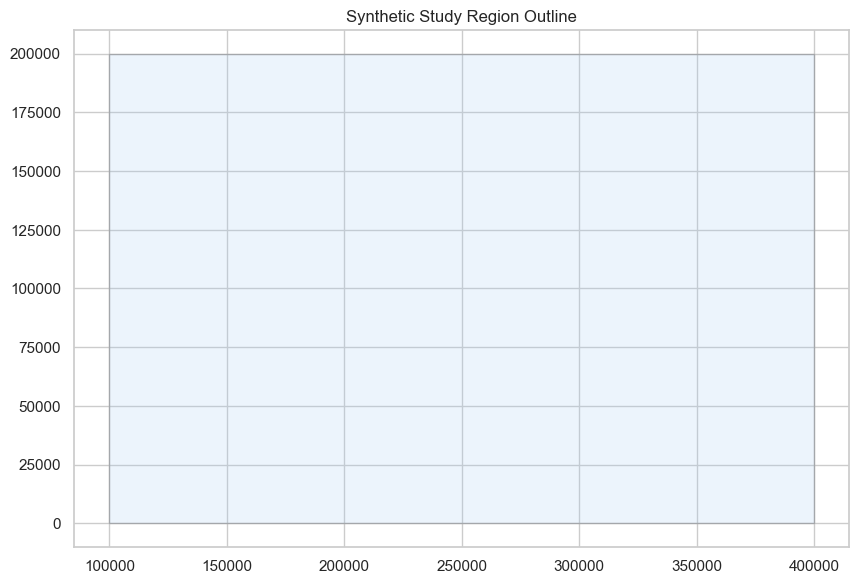

In [8]:
# Create a boundary for our synthetic region for visual context
region_poly = Polygon([(MIN_X, MIN_Y), (MAX_X, MIN_Y), (MAX_X, MAX_Y), (MIN_X, MAX_Y)])
region_gdf = gpd.GeoDataFrame([{'id':1, 'geometry':region_poly}], crs=REGION_CRS)

print("Setup complete. Synthetic region defined.")
region_gdf.plot(alpha=0.2, edgecolor='k')
plt.title("Synthetic Study Region Outline")
plt.show()

#%% md
## Iteration 1: Simple Demand Clustering & Centroid Placement

**Objective:** Identify a single "optimal" location for a facility by finding the center of the largest concentration of demand.

**Synthetic Data:** We'll generate `N_DEMAND_POINTS` randomly within our defined region. To make it more interesting, we'll create a few "hotspots" where demand is more concentrated.

**Methodology:**
1.  Generate demand points with some clustering.
2.  Apply K-Means clustering to group these demand points. We'll use `k=K_FACILITIES` for now, but for this iteration, we're interested in the properties of these clusters.
3.  Identify the "largest" cluster (most demand points).
4.  Place a single facility at the centroid (mean coordinate) of this largest cluster.

**Explanation:** K-Means helps to partition data into `k` distinct groups. The centroid of a cluster represents its center. Placing a facility at the centroid of the most populous cluster is a very basic first step in targeting areas of high need.


Generated 300 demand points for Iteration 1.
Largest cluster is label 0 with centroid at (361329, 49194).


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_23297/524831797.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  demand_colors=demand_gdf_iter1['cluster_label'].map(plt.cm.get_cmap('viridis', K_FACILITIES))) # Color by cluster


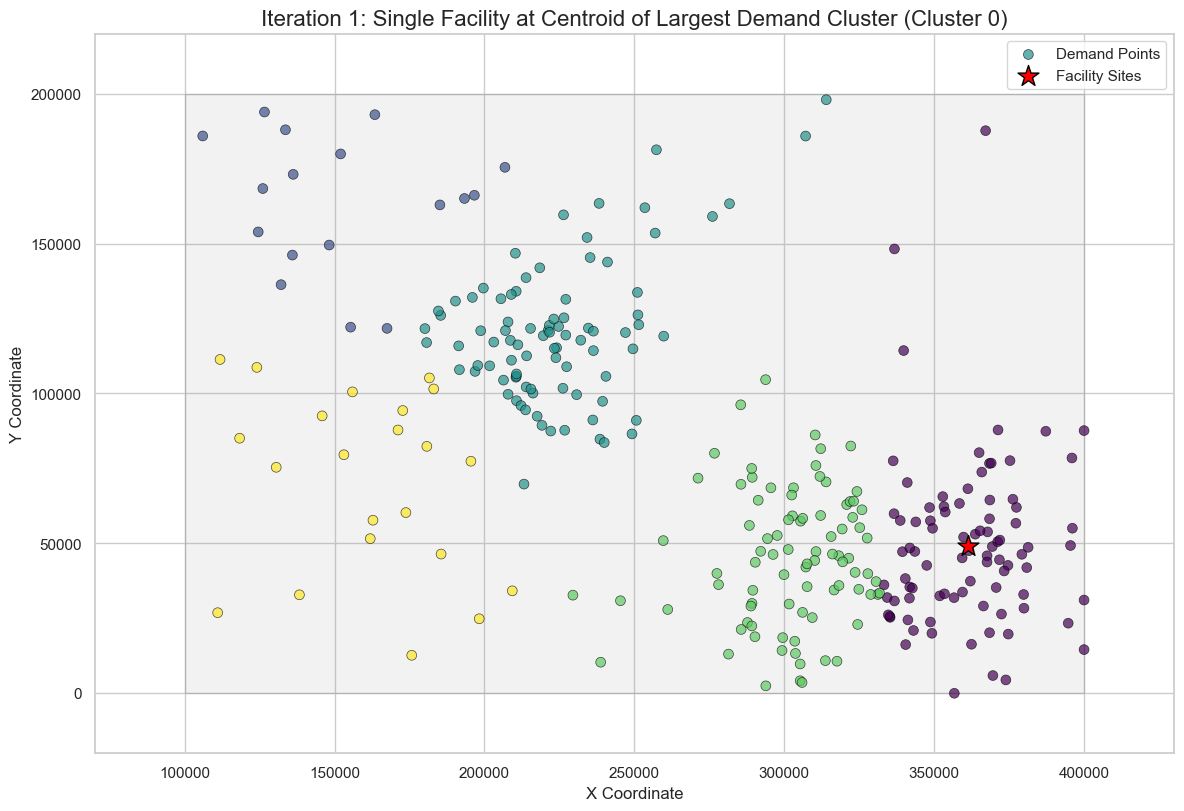

In [10]:
#%%
# --- Iteration 1: Data Generation ---
np.random.seed(42) # for reproducibility

# Create a few hotspots
n_hotspots = 3
hotspot_centers_x = np.random.uniform(MIN_X + 0.1*(MAX_X-MIN_X), MAX_X - 0.1*(MAX_X-MIN_X), n_hotspots)
hotspot_centers_y = np.random.uniform(MIN_Y + 0.1*(MAX_Y-MIN_Y), MAX_Y - 0.1*(MAX_Y-MIN_Y), n_hotspots)
hotspot_spread = (MAX_X - MIN_X) / 15 # Spread of points around hotspot

demand_x_coords_iter1 = []
demand_y_coords_iter1 = []

# Distribute points among hotspots and some random scatter
points_per_hotspot = N_DEMAND_POINTS // (n_hotspots + 1) # +1 for general scatter

for i in range(n_hotspots):
    demand_x_coords_iter1.extend(np.random.normal(loc=hotspot_centers_x[i], scale=hotspot_spread, size=points_per_hotspot))
    demand_y_coords_iter1.extend(np.random.normal(loc=hotspot_centers_y[i], scale=hotspot_spread, size=points_per_hotspot))

# Add some general random scatter
remaining_points = N_DEMAND_POINTS - len(demand_x_coords_iter1)
demand_x_coords_iter1.extend(np.random.uniform(MIN_X, MAX_X, remaining_points))
demand_y_coords_iter1.extend(np.random.uniform(MIN_Y, MAX_Y, remaining_points))

# Clip to bounds (if normal distribution went outside)
demand_x_coords_iter1 = np.clip(demand_x_coords_iter1, MIN_X, MAX_X)
demand_y_coords_iter1 = np.clip(demand_y_coords_iter1, MIN_Y, MAX_Y)

demand_gdf_iter1 = create_gdf_from_points(demand_x_coords_iter1, demand_y_coords_iter1, REGION_CRS)
print(f"Generated {len(demand_gdf_iter1)} demand points for Iteration 1.")

# --- Iteration 1: K-Means Clustering ---
# We'll use K_FACILITIES clusters, but focus on one for placement
kmeans_iter1 = KMeans(n_clusters=K_FACILITIES, random_state=42, n_init='auto')
# K-Means expects 2D array [n_samples, n_features]
demand_coords_array = np.array(list(zip(demand_gdf_iter1.geometry.x, demand_gdf_iter1.geometry.y)))
demand_gdf_iter1['cluster_label'] = kmeans_iter1.fit_predict(demand_coords_array)

# Get cluster centroids
centroids_iter1 = kmeans_iter1.cluster_centers_
centroids_gdf_iter1 = create_gdf_from_points(centroids_iter1[:, 0], centroids_iter1[:, 1], REGION_CRS, point_type_name="centroid_for_cluster", point_labels=range(K_FACILITIES))

# Find the largest cluster
largest_cluster_label = demand_gdf_iter1['cluster_label'].mode()[0] # mode() gives most frequent
largest_cluster_centroid = centroids_iter1[largest_cluster_label]

# Create a GeoDataFrame for the single "optimal" facility
facility_x_iter1 = [largest_cluster_centroid[0]]
facility_y_iter1 = [largest_cluster_centroid[1]]
single_facility_gdf_iter1 = create_gdf_from_points(facility_x_iter1, facility_y_iter1, REGION_CRS)

print(f"Largest cluster is label {largest_cluster_label} with centroid at ({largest_cluster_centroid[0]:.0f}, {largest_cluster_centroid[1]:.0f}).")

# --- Iteration 1: Visualization ---
plot_scenario(demand_gdf_iter1,
              facility_gdf=single_facility_gdf_iter1,
              title=f"Iteration 1: Single Facility at Centroid of Largest Demand Cluster (Cluster {largest_cluster_label})",
              region_boundary_gdf=region_gdf,
              demand_colors=demand_gdf_iter1['cluster_label'].map(plt.cm.get_cmap('viridis', K_FACILITIES))) # Color by cluster


## Iteration 2: Multi-Facility Placement using K-Means Centroids

**Objective:** Extend the previous approach to place multiple facilities, one at the centroid of each identified demand cluster.

**Methodology:**
1.  Use the same clustered demand points from Iteration 1 (or regenerate if desired).
2.  Apply K-Means clustering with `k = K_FACILITIES`.
3.  Place one facility at the centroid of each of the `k` clusters.
4.  Visualize which demand points are "served" by (i.e., closest to) each facility.

**Explanation:** This is a common heuristic for initial multi-facility placement. Each K-Means centroid represents a center of local demand. By placing facilities at these centroids, we aim to provide relatively good accessibility for each cluster. However, this method doesn't explicitly consider travel distances beyond the clustering process itself, nor does it account for service capacity or overlap.


Placed 5 facilities at K-Means cluster centroids.


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_23297/3359312821.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  demand_colors=demand_gdf_iter1['cluster_label'].map(plt.cm.get_cmap('viridis', K_FACILITIES)))


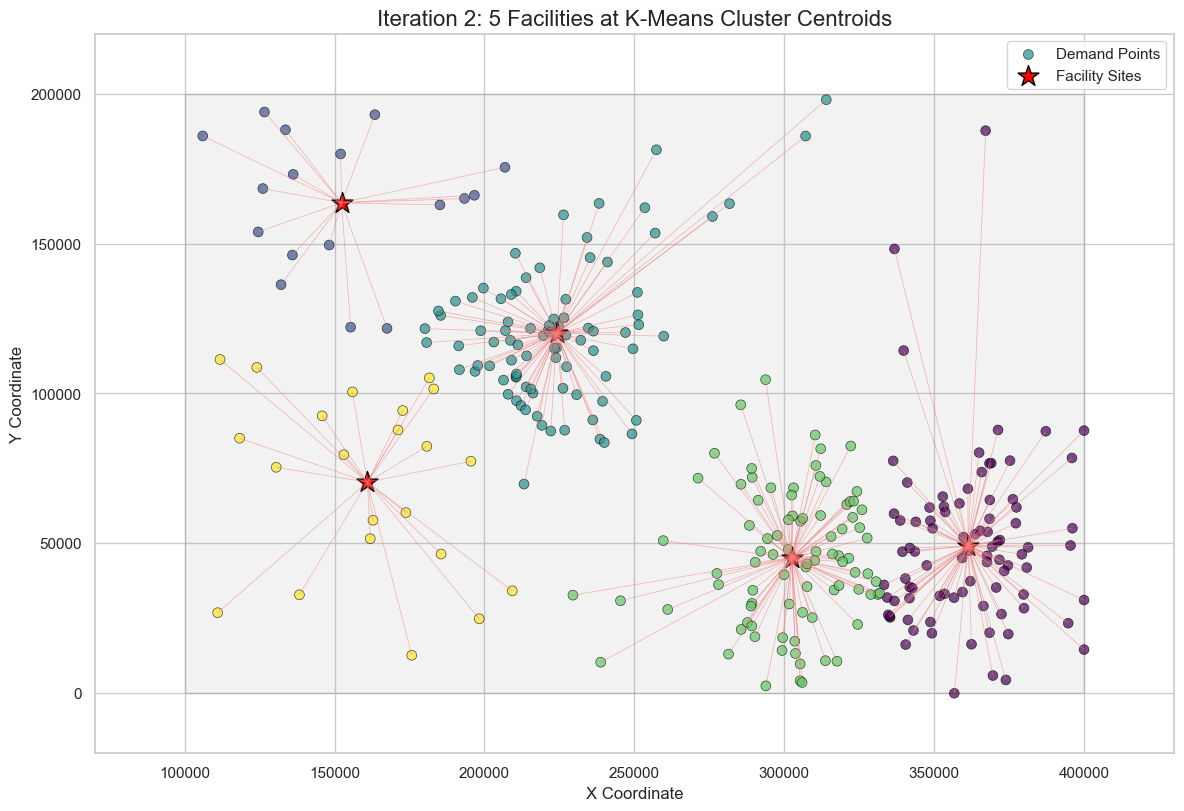

In [11]:
# --- Iteration 2: Using K-Means Centroids for Multiple Facilities ---
# We already have demand_gdf_iter1 with 'cluster_label' and centroids_gdf_iter1 from the previous step.
# The centroids_gdf_iter1 now represents our K_FACILITIES.

# To visualize which demand point is served by which facility (centroid),
# we can assign each demand point to its nearest centroid.
# This is implicitly what K-Means does, so demand_gdf_iter1['cluster_label'] already tells us this.

# Create lines from demand points to their assigned facility (cluster centroid)
lines_iter2 = []
for idx, demand_point in demand_gdf_iter1.iterrows():
    assigned_cluster = demand_point['cluster_label']
    facility_geom = centroids_gdf_iter1.iloc[assigned_cluster].geometry
    line = LineString([demand_point.geometry, facility_geom])
    lines_iter2.append({'geometry': line, 'cluster_label': assigned_cluster})

lines_gdf_iter2 = gpd.GeoDataFrame(lines_iter2, crs=REGION_CRS)

print(f"Placed {K_FACILITIES} facilities at K-Means cluster centroids.")

# --- Iteration 2: Visualization ---
plot_scenario(demand_gdf_iter1,
              facility_gdf=centroids_gdf_iter1, # Centroids are now facilities
              title=f"Iteration 2: {K_FACILITIES} Facilities at K-Means Cluster Centroids",
              region_boundary_gdf=region_gdf,
              lines_gdf=lines_gdf_iter2,
              demand_colors=demand_gdf_iter1['cluster_label'].map(plt.cm.get_cmap('viridis', K_FACILITIES)))


## Iteration 3: Greedy Coverage Maximization

**Objective:** Place a fixed number of facilities from a set of candidate locations to maximize the number of demand points covered within a defined service radius.

**Synthetic Data:**
- Demand points (can reuse from Iteration 1 or generate new ones).
- A set of `N_CANDIDATE_SITES` randomly distributed across the region.

**Methodology (Greedy Algorithm):**
1. Define a `SERVICE_RADIUS` around each potential facility.
2. Initialize all demand points as "uncovered".
3. For `i` from 1 to `K_FACILITIES` (number of facilities to place):
    a. For each *remaining* candidate site, calculate how many *currently uncovered* demand points it would cover if a facility were placed there.
    b. Select the candidate site that provides the maximum coverage of *newly covered* demand points.
    c. Add this site to the list of chosen facility locations.
    d. Mark all demand points covered by this new facility as "covered".
    e. Remove the chosen site from the list of candidates.

**Explanation:** This is a heuristic approach. It's "greedy" because at each step, it makes the locally optimal choice (picking the site that covers the most *currently* uncovered points) without looking ahead to see if that choice might prevent a better overall solution later. It's relatively simple to implement and often provides good, though not always globally optimal, solutions for coverage problems.


Using 300 demand points and 50 candidate sites for Iteration 3.
Facility 1: Selected candidate ID 26, covering 60 new demand points.
Facility 2: Selected candidate ID 0, covering 52 new demand points.
Facility 3: Selected candidate ID 38, covering 37 new demand points.
Facility 4: Selected candidate ID 4, covering 32 new demand points.
Facility 5: Selected candidate ID 37, covering 18 new demand points.
Greedy algorithm placed 5 facilities.
Total demand points covered: 199 out of 300 (66.33%).


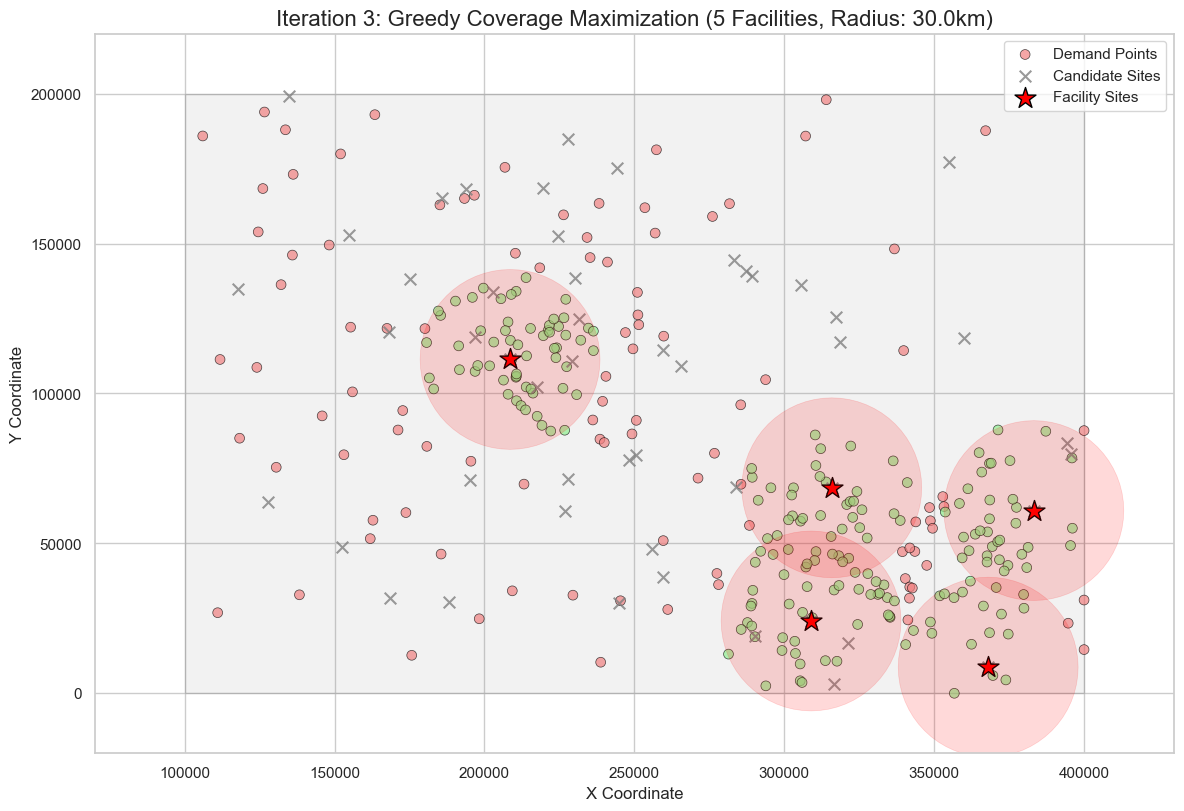

In [12]:
# --- Iteration 3: Data Generation ---
np.random.seed(123) # New seed for this iteration
# Using the same demand points from Iteration 1 (demand_gdf_iter1) for consistency
# Or, generate new ones:
# demand_x_iter3 = np.random.uniform(MIN_X, MAX_X, N_DEMAND_POINTS)
# demand_y_iter3 = np.random.uniform(MIN_Y, MAX_Y, N_DEMAND_POINTS)
# demand_gdf_iter3 = create_gdf_from_points(demand_x_iter3, demand_y_iter3, REGION_CRS)
demand_gdf_iter3 = demand_gdf_iter1.copy() # Use existing demand points
demand_gdf_iter3['covered'] = False # Track coverage status
demand_gdf_iter3['id'] = range(len(demand_gdf_iter3)) # Unique ID for demand points

# Generate candidate sites
candidate_x_iter3 = np.random.uniform(MIN_X, MAX_X, N_CANDIDATE_SITES)
candidate_y_iter3 = np.random.uniform(MIN_Y, MAX_Y, N_CANDIDATE_SITES)
candidate_gdf_iter3 = create_gdf_from_points(candidate_x_iter3, candidate_y_iter3, REGION_CRS)
candidate_gdf_iter3['id'] = range(len(candidate_gdf_iter3)) # Unique ID for candidates

print(f"Using {len(demand_gdf_iter3)} demand points and {len(candidate_gdf_iter3)} candidate sites for Iteration 3.")

# --- Iteration 3: Greedy Coverage Algorithm ---
selected_facility_sites_iter3 = []
selected_facility_geoms_iter3 = [] # Store geometries for plotting coverage
coverage_polygons_iter3 = []

# Make a copy of candidate sites to modify
remaining_candidate_gdf = candidate_gdf_iter3.copy()

for i in range(K_FACILITIES):
    best_candidate_id = -1
    max_newly_covered_count = -1
    best_newly_covered_demand_ids = []

    if remaining_candidate_gdf.empty:
        print("No more candidate sites left.")
        break

    # Iterate through each remaining candidate site
    for cand_idx, candidate in remaining_candidate_gdf.iterrows():
        candidate_geom = candidate.geometry
        newly_covered_count = 0
        current_newly_covered_demand_ids = []

        # Check coverage for *uncovered* demand points
        # This can be slow with many points/candidates. Spatial indexing (e.g., R-tree) would optimize.
        # For simplicity, we do direct distance checks.
        uncovered_demand_gdf = demand_gdf_iter3[~demand_gdf_iter3['covered']]
        
        # Create a buffer (circle) around the candidate site
        coverage_buffer = candidate_geom.buffer(SERVICE_RADIUS)
        
        # Find demand points within this buffer
        # Using GeoPandas' sjoin for spatial relationship is more efficient than manual iteration for large datasets
        # but for clarity of the greedy step-by-step, let's do a distance check within the loop for now.
        # A more geopandas-idiomatic way would be to precompute all potential coverages.
        
        potentially_covered = uncovered_demand_gdf[uncovered_demand_gdf.geometry.within(coverage_buffer)]
        newly_covered_count = len(potentially_covered)
        current_newly_covered_demand_ids = potentially_covered['id'].tolist()

        if newly_covered_count > max_newly_covered_count:
            max_newly_covered_count = newly_covered_count
            best_candidate_id = candidate['id']
            best_newly_covered_demand_ids = current_newly_covered_demand_ids
            best_candidate_geom = candidate_geom # Store the geometry of the best candidate

    if best_candidate_id != -1:
        print(f"Facility {i+1}: Selected candidate ID {best_candidate_id}, covering {max_newly_covered_count} new demand points.")
        selected_facility_sites_iter3.append(remaining_candidate_gdf[remaining_candidate_gdf['id'] == best_candidate_id].iloc[0])
        selected_facility_geoms_iter3.append(best_candidate_geom)
        coverage_polygons_iter3.append(best_candidate_geom.buffer(SERVICE_RADIUS))

        # Update coverage status of demand points
        demand_gdf_iter3.loc[demand_gdf_iter3['id'].isin(best_newly_covered_demand_ids), 'covered'] = True
        
        # Remove selected candidate from remaining candidates
        remaining_candidate_gdf = remaining_candidate_gdf[remaining_candidate_gdf['id'] != best_candidate_id]
    else:
        print(f"Facility {i+1}: No candidate could cover any new demand points. Stopping.")
        break

# Create GeoDataFrames for selected facilities and their coverage areas
if selected_facility_sites_iter3:
    final_facilities_gdf_iter3 = gpd.GeoDataFrame(pd.DataFrame(selected_facility_sites_iter3), geometry='geometry', crs=REGION_CRS)
    coverage_gdf_iter3 = gpd.GeoDataFrame(geometry=coverage_polygons_iter3, crs=REGION_CRS)
else:
    final_facilities_gdf_iter3 = None # Handle case where no facilities are selected
    coverage_gdf_iter3 = None

total_covered_iter3 = demand_gdf_iter3['covered'].sum()
print(f"Greedy algorithm placed {len(selected_facility_sites_iter3)} facilities.")
print(f"Total demand points covered: {total_covered_iter3} out of {len(demand_gdf_iter3)} ({total_covered_iter3/len(demand_gdf_iter3)*100:.2f}%).")


# --- Iteration 3: Visualization ---
# Color demand points by coverage status
demand_colors_iter3 = demand_gdf_iter3['covered'].map({True: 'lightgreen', False: 'lightcoral'})

plot_scenario(demand_gdf_iter3,
              facility_gdf=final_facilities_gdf_iter3,
              candidate_gdf=candidate_gdf_iter3, # Show all original candidates
              title=f"Iteration 3: Greedy Coverage Maximization ({len(selected_facility_sites_iter3)} Facilities, Radius: {SERVICE_RADIUS/1000}km)",
              region_boundary_gdf=region_gdf,
              coverage_polygons_gdf=coverage_gdf_iter3,
              demand_colors=demand_colors_iter3)


## Iteration 4: Basic Location-Allocation Heuristic (P-Median like)

**Objective:** Place `K_FACILITIES` to minimize the average (or total) distance from demand points to their nearest assigned facility. This is a simplified iterative heuristic that mimics aspects of the P-Median problem or Weber problem.

**Synthetic Data:**
- Demand points (can reuse from Iteration 1).
- Initial facility locations: We can use the K-Means centroids from Iteration 2 as a starting point, or generate random initial sites.

**Methodology (Iterative Location-Allocation Heuristic):**
1.  **Initialization:** Start with `K_FACILITIES` initial facility locations.
2.  **Assignment Step:** Assign each demand point to its closest facility (based on Euclidean distance).
3.  **Update Step (Relocation):** For each facility, recalculate its location as the centroid (mean coordinate) of all demand points currently assigned to it.
4.  **Repeat:** Repeat steps 2 and 3 for a fixed number of iterations or until the facility locations stabilize (i.e., change very little between iterations).

**Explanation:** This heuristic is similar to how the K-Means algorithm itself works. It tries to find a set of facility locations that are "central" to the demand they serve. While not a formal P-Median solver (which often involves more complex optimization like linear programming or specialized heuristics like Teitz and Bart), this iterative approach is intuitive and often improves facility placements by reducing overall travel burden.


Starting Iteration 4 with 5 K-Means centroids as initial facility locations.

Running Location-Allocation Heuristic for up to 20 iterations...
Iteration 1: Total demand-to-facility distance = 8,441,482
Convergence reached at iteration 1. Max facility movement: 0.00


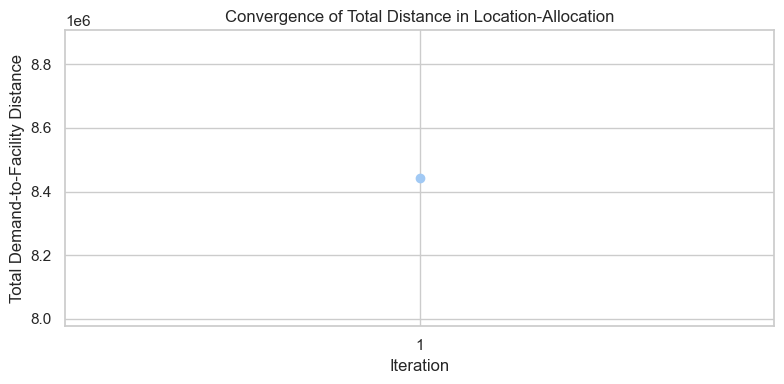

/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_23297/1013064433.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  demand_colors=demand_gdf_iter4['assigned_facility_idx'].map(plt.cm.get_cmap('viridis', K_FACILITIES)))


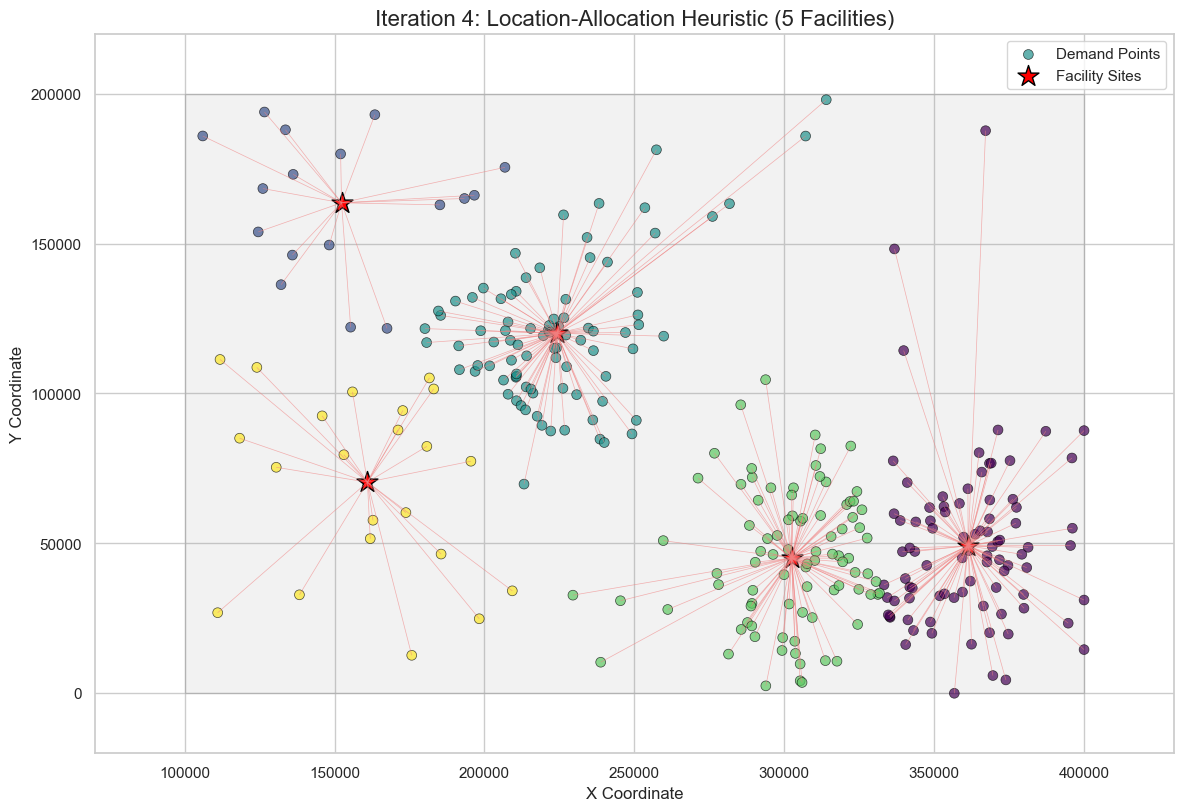

In [13]:
# --- Iteration 4: Data and Initialization ---
np.random.seed(777)
demand_gdf_iter4 = demand_gdf_iter1.copy() # Use demand points from Iteration 1

# Initial facility locations: Use K-Means centroids from Iteration 2 as a good start
if 'centroids_gdf_iter1' in locals() and len(centroids_gdf_iter1) == K_FACILITIES:
    current_facility_coords = np.array(list(zip(centroids_gdf_iter1.geometry.x, centroids_gdf_iter1.geometry.y)))
    print(f"Starting Iteration 4 with {K_FACILITIES} K-Means centroids as initial facility locations.")
else: # Fallback to random initial sites if centroids not available or wrong number
    print(f"Warning: K-Means centroids not suitable. Initializing {K_FACILITIES} facilities randomly for Iteration 4.")
    initial_facility_x = np.random.uniform(MIN_X, MAX_X, K_FACILITIES)
    initial_facility_y = np.random.uniform(MIN_Y, MAX_Y, K_FACILITIES)
    current_facility_coords = np.array(list(zip(initial_facility_x, initial_facility_y)))

demand_coords_array_iter4 = np.array(list(zip(demand_gdf_iter4.geometry.x, demand_gdf_iter4.geometry.y)))

# --- Iteration 4: Location-Allocation Heuristic ---
MAX_ITERATIONS = 20
CONVERGENCE_THRESHOLD = 1.0 # Stop if max movement of any facility is less than this (in map units)

print(f"\nRunning Location-Allocation Heuristic for up to {MAX_ITERATIONS} iterations...")
history_total_dist = []

for iteration in range(MAX_ITERATIONS):
    # 1. Assignment Step: Assign demand points to nearest facility
    # distances: rows are demand points, columns are facilities
    distances = cdist(demand_coords_array_iter4, current_facility_coords, metric='euclidean')
    assigned_facility_indices = np.argmin(distances, axis=1) # Index of the closest facility for each demand point
    demand_gdf_iter4['assigned_facility_idx'] = assigned_facility_indices
    
    # Calculate total distance for this iteration (optional, for monitoring)
    total_distance = distances[np.arange(len(assigned_facility_indices)), assigned_facility_indices].sum()
    history_total_dist.append(total_distance)
    print(f"Iteration {iteration + 1}: Total demand-to-facility distance = {total_distance:,.0f}")

    # 2. Update Step: Relocate facilities to centroid of assigned demand
    new_facility_coords = np.zeros_like(current_facility_coords)
    moved = False
    max_movement_this_iteration = 0.0

    for fac_idx in range(K_FACILITIES):
        # Get demand points assigned to this facility
        assigned_demand_points = demand_coords_array_iter4[demand_gdf_iter4['assigned_facility_idx'] == fac_idx]
        
        if len(assigned_demand_points) > 0:
            # Calculate new centroid for this facility
            new_centroid = np.mean(assigned_demand_points, axis=0)
            new_facility_coords[fac_idx] = new_centroid
            
            # Check movement
            movement = np.linalg.norm(current_facility_coords[fac_idx] - new_facility_coords[fac_idx])
            if movement > 0.01 : # Check if actually moved beyond float precision
                moved = True
            if movement > max_movement_this_iteration:
                max_movement_this_iteration = movement
        else:
            # No demand points assigned, keep facility where it is (or handle differently, e.g., remove/reposition)
            new_facility_coords[fac_idx] = current_facility_coords[fac_idx]
            print(f"  Facility {fac_idx} had no demand points assigned, location unchanged.")

    current_facility_coords = new_facility_coords

    if not moved or max_movement_this_iteration < CONVERGENCE_THRESHOLD :
        print(f"Convergence reached at iteration {iteration + 1}. Max facility movement: {max_movement_this_iteration:.2f}")
        break
    if iteration == MAX_ITERATIONS -1:
         print(f"Max iterations reached. Max facility movement in last step: {max_movement_this_iteration:.2f}")


final_facilities_gdf_iter4 = create_gdf_from_points(current_facility_coords[:, 0], current_facility_coords[:, 1], REGION_CRS, point_labels=range(K_FACILITIES))

# Create lines from demand points to their final assigned facility
lines_iter4 = []
for idx, demand_point in demand_gdf_iter4.iterrows():
    assigned_fac_idx = demand_point['assigned_facility_idx']
    facility_geom = final_facilities_gdf_iter4.iloc[assigned_fac_idx].geometry
    line = LineString([demand_point.geometry, facility_geom])
    lines_iter4.append({'geometry': line, 'assigned_facility_idx': assigned_fac_idx})

lines_gdf_iter4 = gpd.GeoDataFrame(lines_iter4, crs=REGION_CRS)

# --- Iteration 4: Visualization ---
# Plot convergence history
plt.figure(figsize=(8,4))
plt.plot(range(1, len(history_total_dist) + 1), history_total_dist, marker='o', linestyle='-')
plt.title("Convergence of Total Distance in Location-Allocation")
plt.xlabel("Iteration")
plt.ylabel("Total Demand-to-Facility Distance")
plt.grid(True)
plt.xticks(range(1, len(history_total_dist) + 1))
plt.tight_layout()
plt.show()


# Plot final locations
plot_scenario(demand_gdf_iter4,
              facility_gdf=final_facilities_gdf_iter4,
              title=f"Iteration 4: Location-Allocation Heuristic ({K_FACILITIES} Facilities)",
              region_boundary_gdf=region_gdf,
              lines_gdf=lines_gdf_iter4,
              demand_colors=demand_gdf_iter4['assigned_facility_idx'].map(plt.cm.get_cmap('viridis', K_FACILITIES)))


## Conclusion and Further Steps

This notebook demonstrated several iterative approaches to site location optimization using synthetic data:

1.  **Simple Demand Clustering (K-Means Centroid):** Useful for identifying a single, highly central location based on demand concentration.
2.  **Multi-Facility K-Means Placement:** Extends clustering to place multiple facilities, offering a basic distribution based on demand groups.
3.  **Greedy Coverage Maximization:** Focuses on ensuring as many demand points as possible are within a service radius of a facility, good for equity of access.
4.  **Location-Allocation Heuristic:** Aims to minimize overall travel distance/burden, iteratively refining facility locations to be more central to the populations they serve.

**Limitations and Next Steps:**

* **Real-world Data:** These examples used synthetic data. Real-world applications would require actual population data, road networks for accurate travel times (instead of Euclidean distance), existing facility locations, and geographical constraints.
* **Capacity Constraints:** We haven't considered the capacity of facilities. Real models often need to balance demand with how many people a facility can serve (capacitated location models).
* **Travel Costs/Time:** Euclidean distance is a simplification. Using road network distances or travel times (e.g., via OSRM, Google Maps API, or specialized libraries like `pandana` or `geosnap` if network data is available) would be more realistic.
* **More Advanced Solvers:** For complex problems, especially P-Median, P-Center, or capacitated models, dedicated optimization solvers (e.g., Gurobi, CPLEX, or open-source ones like PuLP with CBC/GLPK) are typically used to find provably optimal or near-optimal solutions.
* **Multi-Objective Optimization:** Often, there are multiple competing objectives (e.g., minimize travel, maximize coverage, minimize cost, ensure equity). Multi-objective optimization techniques would be needed.
* **Accessibility Metrics:** More sophisticated accessibility metrics (e.g., gravity models, two-step floating catchment area methods) can provide richer insights into spatial access.

This notebook provides a foundational understanding. The specific LSOA/IMD data you worked with earlier could serve as the "demand points" (perhaps weighted by IMD score or population counts if available) in a more realistic application of these techniques for the South West region.
